In [1]:
from mplsoccer.pitch import Pitch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
import fuzzymatcher
import seaborn as sns
import matplotlib as mpl
%config InlineBackend.figure_format='retina'

In [2]:
WYSCOUT = os.path.join('..', 'data', 'wyscout')
STATSBOMB = os.path.join('..', 'data', 'statsbomb')

Load data

In [3]:
df_wyscout_event = pd.read_parquet(os.path.join(WYSCOUT, 'event_overlap.parquet'))
df_statsbomb_event = pd.read_parquet(os.path.join(STATSBOMB, 'event.parquet'))
df_wyscout_match = pd.read_parquet(os.path.join(WYSCOUT, 'match.parquet'))
df_wyscout_match_overlap = pd.read_parquet(os.path.join(WYSCOUT, 'match_overlap.parquet'))
df_wyscout_player = pd.read_parquet(os.path.join(WYSCOUT, 'player.parquet'))
df_statsbomb_match = pd.read_parquet(os.path.join(STATSBOMB, 'match.parquet'))
df_statsbomb_tactic = pd.read_parquet(os.path.join(STATSBOMB, 'tactic.parquet'))

Number of passes for starting players from StatsBomb data

In [4]:
#df_start = df_statsbomb_event.loc[df_statsbomb_event.type_name=='Starting XI', ['id']]
#df_start = df_start.merge(df_statsbomb_tactic, how='left')
#df_start = df_start[['match_id', 'player_id']]
#df_pass = df_statsbomb_event[df_statsbomb_event.type_name == 'Pass'].copy()
#df_pass_start = df_start.merge(df_pass, on=['match_id', 'player_id'], how='inner')
#df_pass_start.groupby(['match_id','player_id']).type_name.count().mean()
# 42.148323828812025

Games per competition

In [5]:
df_statsbomb_match.competition_name.value_counts()

La Liga                    452
FA Women's Super League    194
FIFA World Cup              64
Women's World Cup           52
NWSL                        36
Premier League              32
Champions League            14
Name: competition_name, dtype: int64

In [6]:
df_statsbomb_match.groupby(['competition_name', 'season_name']).match_id.count()

competition_name         season_name
Champions League         2003/2004        1
                         2004/2005        1
                         2006/2007        1
                         2008/2009        1
                         2009/2010        1
                         2010/2011        1
                         2011/2012        1
                         2012/2013        1
                         2013/2014        1
                         2014/2015        1
                         2015/2016        1
                         2016/2017        1
                         2017/2018        1
                         2018/2019        1
FA Women's Super League  2018/2019      106
                         2019/2020       88
FIFA World Cup           2018            64
La Liga                  2004/2005        7
                         2005/2006       17
                         2006/2007       26
                         2007/2008       28
                         2008/2009     

% Shots belonging to Barcelona 

In [7]:
num_barca_shots = ((df_statsbomb_event.team_name=='Barcelona') & (df_statsbomb_event.type_name=='Shot')).sum()
num_total_shots = (df_statsbomb_event.type_name=='Shot').sum()
print('Proportion of shots taken by Barcelona in StatsBomb data:', round(num_barca_shots/num_total_shots * 100, 1))

Proportion of shots taken by Barcelona in StatsBomb data: 33.3


Number shots relating to Messi

In [8]:
num_messi_shots = ((df_statsbomb_event.player_name == 'Lionel Andrés Messi Cuccittini') &
                   (df_statsbomb_event.type_name=='Shot')).sum()

In [9]:
print('Number of Messi shots in the StatsBomb dataset', num_messi_shots)
print('Number of total shots in the StatsBomb dataset', num_total_shots)

Number of Messi shots in the StatsBomb dataset 2031
Number of total shots in the StatsBomb dataset 21876


Combine wyscout match

In [10]:
df_wyscout_match = pd.concat([df_wyscout_match, df_wyscout_match_overlap])

Games in the Wyscout data

In [11]:
print(len(df_wyscout_match))

1941


In [12]:
df_wyscout_match.groupby(['season_name', 'competition_name']).season_name.count()

season_name  competition_name
2016         UEFA Euro            51
2017/2018    Bundesliga          306
             La Liga             380
             Ligue 1             380
             Premier League      380
             Serie A             380
2018         FIFA World Cup       64
Name: season_name, dtype: int64

In [13]:
df_statsbomb_shots = df_statsbomb_event[(df_statsbomb_event.type_name=='Shot')&
                                        (df_statsbomb_event.event_type_name!='Penalty')].dropna(how='all', axis=1).copy()
df_wyscout_shots = df_wyscout_event[((df_wyscout_event.eventName=='Shot')|
                                    #(df_wyscout_event.subEventName.isin(['Free kick shot', 'Penalty']))].copy()
                                    (df_wyscout_event.subEventName=='Free kick shot')) &
                                    (df_wyscout_event['matchPeriod']!='P')].copy()

Subset StatsBomb overlap

In [14]:
mask_sb_overlap = ((df_statsbomb_match.competition_name == 'FIFA World Cup')|
                   ((df_statsbomb_match.competition_name == 'La Liga') & (df_statsbomb_match.season_name == '2017/2018')))
overlap_id = df_statsbomb_match.loc[mask_sb_overlap, 'match_id']
df_statsbomb_event = df_statsbomb_event[df_statsbomb_event.match_id.isin(overlap_id)].copy()

Number of non-penalty shots in the Wyscout data

In [15]:
mask_shot_wy = (((df_wyscout_event.eventName=='Shot') | (df_wyscout_event.subEventName=='Free kick shot')) & 
                (df_wyscout_event['matchPeriod']!='P'))
print('Number of non-penalty shots:', mask_shot_wy.sum())

Number of non-penalty shots: 2420


Number of no-penalty shots in the StatsBomb data

In [16]:
mask_shot_sb = (df_statsbomb_event.type_name == 'Shot') & (df_statsbomb_event.event_type_name!='Penalty')
print('Number of non-penalty shots - StatsBomb:', mask_shot_sb.sum())

Number of non-penalty shots - StatsBomb: 2604


Add match_id from other dataset

In [17]:
df_id1 = df_wyscout_match[['match_id', 'home_team_name', 'away_team_name', 'home_score', 'away_score', 'kick_off']].copy()
df_id2 = df_statsbomb_match[['match_id', 'home_team_name', 'away_team_name', 'home_score', 'away_score', 'kick_off']].copy()
df_id1['kick_off'] = pd.to_datetime(df_id1.kick_off.dt.date)
df_id2['kick_off'] = pd.to_datetime(df_id2.kick_off.dt.date)
df_overlap = df_id1.merge(df_id2, on=['home_team_name', 'away_team_name', 'home_score', 'kick_off'], how='inner', 
                          suffixes=['_wyscout', '_statsbomb'])
df_overlap = df_overlap[['match_id_wyscout', 'match_id_statsbomb']]
df_statsbomb_event = df_statsbomb_event.merge(df_overlap, left_on='match_id', right_on='match_id_statsbomb', how='left')
df_wyscout_event = df_wyscout_event.merge(df_overlap, left_on='match_id', right_on='match_id_wyscout', how='left')

Add team name to Wyscout

In [18]:
df_team1 = df_wyscout_match[['home_team_id', 'home_team_name']].copy()
df_team1.rename({'home_team_id': 'team_id','home_team_name': 'team_name'}, axis=1, inplace=True)
df_team2 = df_wyscout_match[['away_team_id', 'away_team_name']].copy()
df_team2.rename({'away_team_id': 'team_id','away_team_name': 'team_name'}, axis=1, inplace=True)
df_teams = pd.concat([df_team1, df_team2]).drop_duplicates()
df_wyscout_event = df_wyscout_event.merge(df_teams, on='team_id', how='left')

Add player name to Wyscout. I am going to seperate out the last part of the name, the first part of the name and anything inbetween. This may not be technically accurate, but it's easier to join

In [19]:
df_wyscout_player['fullName'] = (df_wyscout_player.firstName + ' ' + df_wyscout_player.lastName).str.strip()
player_name_series = df_wyscout_player.fullName.str.split(' ')
df_wyscout_player['firstName'] = player_name_series.apply(lambda x: x[0] if isinstance(x, list) else None)
df_wyscout_player['middleName'] = player_name_series.apply(lambda x: ' '.join(x[1:-1]) if isinstance(x, list) else None)
df_wyscout_player['lastName'] = player_name_series.apply(lambda x: x[-1] if isinstance(x, list) else None)
df_wyscout_player['middleName'] = df_wyscout_player['middleName'].str.strip()
df_wyscout_player['Name'] = ((df_wyscout_player['firstName'] + ' ' + df_wyscout_player['middleName']).str.strip()
                             + ' ' + df_wyscout_player['lastName'])
df_wyscout_event = df_wyscout_event.merge(df_wyscout_player, how='left')

Add player name to StatsBomb

In [20]:
player_name_series = df_statsbomb_event.player_name.str.strip().str.replace(pat='"', repl="'").str.split(' ')
df_statsbomb_event['firstName'] = player_name_series.apply(lambda x: x[0] if isinstance(x, list) else None)
df_statsbomb_event['middleName'] = player_name_series.apply(lambda x: ' '.join(x[1:-1]) if isinstance(x, list) else None)
df_statsbomb_event['middleName'] = df_statsbomb_event['middleName'].str.strip()
df_statsbomb_event['lastName'] = player_name_series.apply(lambda x: x[-1] if isinstance(x, list) else None)
df_statsbomb_event['Name'] = ((df_statsbomb_event['firstName'] + ' ' + df_statsbomb_event['middleName']).str.strip()
                              + ' ' + df_statsbomb_event['lastName'])

Subset non-penalty shots

In [21]:
df_statsbomb_shots = df_statsbomb_event[(df_statsbomb_event.type_name=='Shot')&
                                        (df_statsbomb_event.event_type_name!='Penalty')].dropna(how='all', axis=1).copy()
df_wyscout_shots = df_wyscout_event[((df_wyscout_event.eventName=='Shot')|
                                    #(df_wyscout_event.subEventName.isin(['Free kick shot', 'Penalty']))].copy()
                                    (df_wyscout_event.subEventName=='Free kick shot')) &
                                    (df_wyscout_event['matchPeriod']!='P')].copy()

In [22]:
print('Number of StatsBomb shots:', len(df_statsbomb_shots))
print('Number of Wyscout shots:', len(df_wyscout_shots))

Number of StatsBomb shots: 2604
Number of Wyscout shots: 2420


Add consistent period (in wyscout it's matchPeriod=1H/2H/E1/E2 in StatsBomb its period=1/2/3/4)

In [23]:
df_wyscout_shots['period'] = df_wyscout_shots['matchPeriod'].replace({'1H': 1, '2H': 2, 'E1': 3, 'E2': 4})

Add consistent seconds (eventSec) in Wyscout

In [24]:
df_statsbomb_shots['eventSec'] = ((df_statsbomb_shots.timestamp_minute * 60.) +
                                  (df_statsbomb_shots.timestamp_second) +
                                  (df_statsbomb_shots.timestamp_millisecond/1000.))

Create a combined player id

In [25]:
# merge the two datasets: exact match on names and team name
p1 = df_wyscout_shots[['player_id', 'firstName', 'middleName', 'lastName', 'Name', 'team_name']].drop_duplicates()
p2 = df_statsbomb_shots[['player_id', 'firstName', 'middleName', 'lastName', 'Name', 'team_name']].drop_duplicates()
p3 = p1.merge(p2, how='outer', on=['firstName', 'middleName',
                                   'lastName', 'Name', 'team_name'], suffixes=['_wyscout', '_statsbomb'])
matched = p3[(p3.player_id_wyscout.notnull() & p3.player_id_statsbomb.notnull())].copy()
matched = matched[['player_id_wyscout', 'player_id_statsbomb']].drop_duplicates()
not_matched_statsbomb = p2[~p2.player_id.isin(matched.player_id_statsbomb)].copy()
not_matched_wyscout = p1[~p1.player_id.isin(matched.player_id_wyscout)].copy()
not_matched_wyscout.rename({'player_id': 'player_id_wyscout'}, axis=1, inplace=True)
not_matched_statsbomb.rename({'player_id': 'player_id_statsbomb'}, axis=1, inplace=True)
# Then non exact match using fuzzy matcher
# Note U hand checked the best_match_score threshold (anything above zero was actually a match in this case)
fuzzy_match = fuzzymatcher.fuzzy_left_join(not_matched_wyscout,
                                           not_matched_statsbomb,
                                           left_on=['Name', 'team_name'],
                                           right_on=['Name', 'team_name'],
                                           left_id_col='player_id_wyscout',
                                           right_id_col='player_id_statsbomb')
fuzzy_match = fuzzy_match.loc[fuzzy_match.best_match_score > 0.3, ['player_id_wyscout', 'player_id_statsbomb']]
# all matched
matched = pd.concat([matched, fuzzy_match])
# get not matched
mask_no_match_wy = ~not_matched_wyscout.player_id_wyscout.isin(matched.player_id_wyscout)
not_matched_wyscout = not_matched_wyscout.loc[mask_no_match_wy, ['player_id_wyscout']].copy()
not_matched_wyscout.drop_duplicates(inplace=True)
mask_no_match_sb = ~not_matched_statsbomb.player_id_statsbomb.isin(matched.player_id_statsbomb)
not_matched_statsbomb = not_matched_statsbomb.loc[mask_no_match_sb, ['player_id_statsbomb']].copy()
not_matched_statsbomb.drop_duplicates(inplace=True)
# combined the match/ no match and get a unique id from the index
df_matched_players = pd.concat([matched, not_matched_statsbomb, not_matched_wyscout])
df_matched_players.reset_index(drop=True, inplace=True)
df_matched_players.index.name = 'player_id_combined'
df_matched_players.reset_index(inplace=True)

Add the combined player id to the datasets

In [26]:
df_statsbomb_shots = df_statsbomb_shots.merge(df_matched_players, left_on='player_id', right_on='player_id_statsbomb')
df_wyscout_shots = df_wyscout_shots.merge(df_matched_players, left_on='player_id', right_on='player_id_wyscout')
# hand check merge has not introduced additional shots
print('Number of StatsBomb shots:', len(df_statsbomb_shots))
print('Number of Wyscout shots:', len(df_wyscout_shots))

Number of StatsBomb shots: 2604
Number of Wyscout shots: 2420


Setup the pitches

In [27]:
pitch_statsbomb = Pitch(orientation='vertical', view='half')
pitch_wyscout = Pitch(pitch_type='wyscout', orientation='vertical', view='half')
pitch_statsperform = Pitch(pitch_type='statsperform', orientation='vertical', view='half', line_zorder=3)

Add metadata

In [28]:
df_statsbomb_shots = df_statsbomb_shots.merge(df_statsbomb_match[['match_id', 'metadata_shot_fidelity_version']],
                                              on='match_id', how='left', validate='m:1')

@lemonwatcher says:

1) coordinates denote the bottom-right corner of a cell in a grid, not an actual point, so 1,1 is the top-left square 'yard' of the field (in landscape), even though 0,0 is the true coordinate of the corner flag.

2) some matches have metadata like "xy_fidelity_version" : "2", which means the grid has higher granularity. In this case 0.1,0.1 is the top left cell. We appear to have elided this bit of the docs in the repo, which I will attempt to remedy.

So here we set to the middle of the grid

In [29]:
mask_fidelity = df_statsbomb_shots.metadata_shot_fidelity_version!='2'
df_statsbomb_shots.loc[mask_fidelity, 'x'] = df_statsbomb_shots.loc[mask_fidelity, 'x'] - 0.5
df_statsbomb_shots.loc[mask_fidelity, 'y'] = df_statsbomb_shots.loc[mask_fidelity, 'y'] - 0.5
mask_fidelity = df_statsbomb_shots.metadata_shot_fidelity_version=='2'
df_statsbomb_shots.loc[mask_fidelity, 'x'] = df_statsbomb_shots.loc[mask_fidelity, 'x'] - 0.05
df_statsbomb_shots.loc[mask_fidelity, 'y'] = df_statsbomb_shots.loc[mask_fidelity, 'y'] - 0.05

Standardise to the same coordinate system 105*68

In [30]:
# statsbomb
df_statsbomb_shots[['x', 'end_x']] = ((df_statsbomb_shots[['x', 'end_x']])
                                           / float(pitch_statsbomb.right) * 105.)
df_statsbomb_shots[['y', 'end_y']] = ((float(pitch_statsbomb.bottom) - df_statsbomb_shots[['y', 'end_y']]) 
                                           / float(pitch_statsbomb.bottom)  * 68.)
# wyscout
df_wyscout_shots[['x', 'end_x']] = ((df_wyscout_shots[['x', 'end_x']])
                                    / float(pitch_wyscout.right) * 105.)
df_wyscout_shots[['y', 'end_y']] = ((float(pitch_wyscout.bottom) - df_wyscout_shots[['y', 'end_y']]) 
                                    / float(pitch_wyscout.bottom)  * 68.)

Subset interesting variables

In [31]:
df_statsbomb_shots = df_statsbomb_shots[['id', 'match_id_wyscout', 'player_id_combined', 'eventSec', 'period',
                                         'event_type_name', 'technique_name', 'team_name', 'Name',
                                         'x', 'y', 'end_x', 'end_y', 'end_z',
                                         'body_part_name', 'outcome_name']].copy()

In [32]:
df_wyscout_shots = df_wyscout_shots[['id', 'match_id_wyscout', 'player_id_combined', 'eventSec', 'period',
                                     'team_name', 'Name', 'x', 'y', 'end_x', 'end_y', 'left_foot', 
                                     'right_foot', 'other_body_part', 'goal']].copy()

Merge shots

In [33]:
# sort the dataframe as needed for a merge_asof
df_statsbomb_shots.sort_values('eventSec', inplace=True)
df_wyscout_shots.sort_values('eventSec', inplace=True)
# copy the time column for working out time difference
df_statsbomb_shots['eventSec_statsbomb'] = df_statsbomb_shots.eventSec
df_wyscout_shots['eventSec_wyscout'] = df_wyscout_shots.eventSec
# match to closest shot by time - allow up to 20 second difference
df_statsbomb_shots_merged = pd.merge_asof(df_statsbomb_shots, df_wyscout_shots, on='eventSec', 
                                          by=['match_id_wyscout', 'player_id_combined', 'period'],
                                          suffixes=('_statsbomb', '_wyscout'),
                                          tolerance=26, direction='nearest')
matched_shots = df_statsbomb_shots_merged[df_statsbomb_shots_merged.id_wyscout.notnull()].copy()
unmatched_shots = df_statsbomb_shots_merged[df_statsbomb_shots_merged.id_wyscout.isnull()].copy()
# where statsbomb shot matched to multiple wyscout shots deduplicate
matched_shots['time_diff'] = (abs(matched_shots['eventSec_statsbomb'] - matched_shots['eventSec_wyscout']))
matched_shots.sort_values('time_diff', inplace=True)
matched_shots_dedup = matched_shots.drop_duplicates('id_wyscout', keep='first')
# get the real matches, i.e. the first match for a shot
mask_real_match = matched_shots.id_statsbomb.isin(matched_shots_dedup.id_statsbomb)
df_matched_shots = matched_shots[mask_real_match].copy()  # collect matched shots
# get the unmatched shots
df_wyscout_unmatched = df_wyscout_shots[~df_wyscout_shots.id.isin(df_matched_shots.id_wyscout)].copy()
df_statsbomb_unmatched = df_statsbomb_shots[~df_statsbomb_shots.id.isin(df_matched_shots.id_statsbomb)].copy()
# hand check merge has not introduced additional shots
print('Number of StatsBomb shots:', len(df_statsbomb_unmatched) + len(df_matched_shots))
print('Number of Wyscout shots:', len(df_wyscout_unmatched) + len(df_matched_shots))

Number of StatsBomb shots: 2604
Number of Wyscout shots: 2420


Second merge to catch a few more

In [34]:
match_second = pd.merge_asof(df_statsbomb_unmatched, df_wyscout_unmatched, on='eventSec', 
                             by=['match_id_wyscout', 'player_id_combined', 'period'],
                             suffixes=('_statsbomb', '_wyscout'),
                             tolerance=26, direction='nearest')
df_matched_shots = pd.concat([df_matched_shots, match_second[match_second.id_wyscout.notnull()]])
df_wyscout_unmatched = df_wyscout_unmatched[~df_wyscout_unmatched.id.isin(df_matched_shots.id_wyscout)]
df_statsbomb_unmatched = df_statsbomb_unmatched[~df_statsbomb_unmatched.id.isin(df_matched_shots.id_statsbomb)]
# hand check merge has not introduced additional shots
print('Number of StatsBomb shots:', len(df_statsbomb_unmatched) + len(df_matched_shots))
print('Number of Wyscout shots:', len(df_wyscout_unmatched) + len(df_matched_shots))

Number of StatsBomb shots: 2604
Number of Wyscout shots: 2420


In [35]:
print('Number of matched shots:', len(df_matched_shots))
print('Number of unmatched Wyscout shots:', len(df_wyscout_unmatched))
print('Number of unmatched StatsBomb shots:', len(df_statsbomb_unmatched))

Number of matched shots: 2386
Number of unmatched Wyscout shots: 34
Number of unmatched StatsBomb shots: 218


Plot unmatched StatsBomb shots

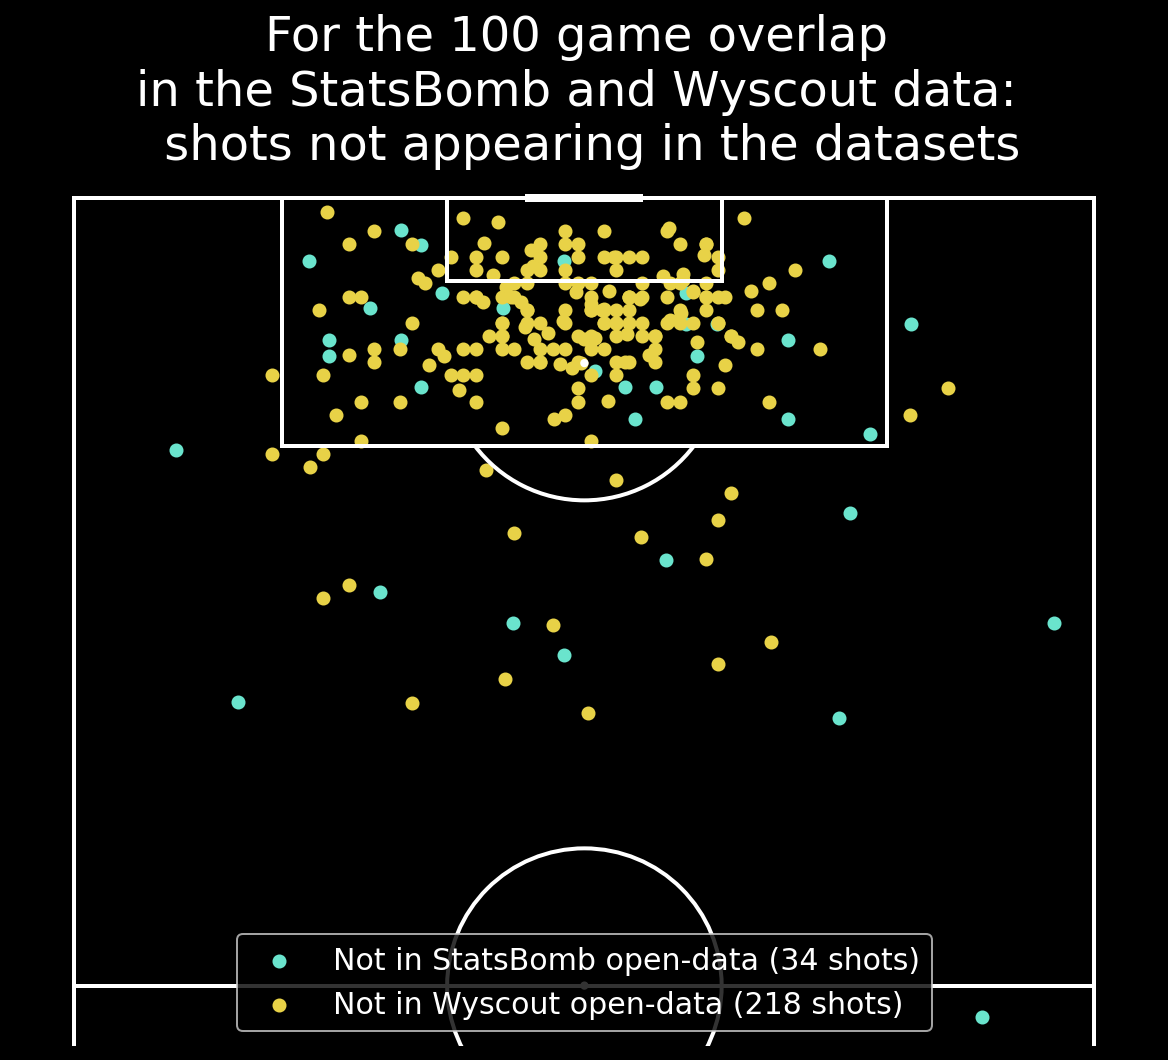

In [36]:
plt.style.use('dark_background')
pitch = Pitch(pitch_type='statsperform', figsize=(8, 9), view='half', pad_top=12, line_zorder=3,
             constrained_layout=True, tight_layout=False, orientation='vertical')
fig, ax = pitch.draw()
pitch.scatter(df_wyscout_unmatched.x, df_wyscout_unmatched.y, ax=ax, c='#6ae4cd',
              label=f'Not in StatsBomb open-data ({len(df_wyscout_unmatched)} shots)')
pitch.scatter(df_statsbomb_unmatched.x, df_statsbomb_unmatched.y, ax=ax, c='#e8d247',
              label=f'Not in Wyscout open-data ({len(df_statsbomb_unmatched)} shots)')
ax.legend(fontsize=15, loc='lower center',)# bbox_to_anchor=(0.5, 0.2, 0.2, 0.5))
fig.suptitle('For the 100 game overlap \nin the StatsBomb and Wyscout data: \n shots not appearing in the datasets',
             y=0.9, fontsize=24);
fig.savefig(os.path.join('figures', 'overlap_shot_differences.png'), bbox_inches = 'tight', pad_inches = 0.2)

Plot difference

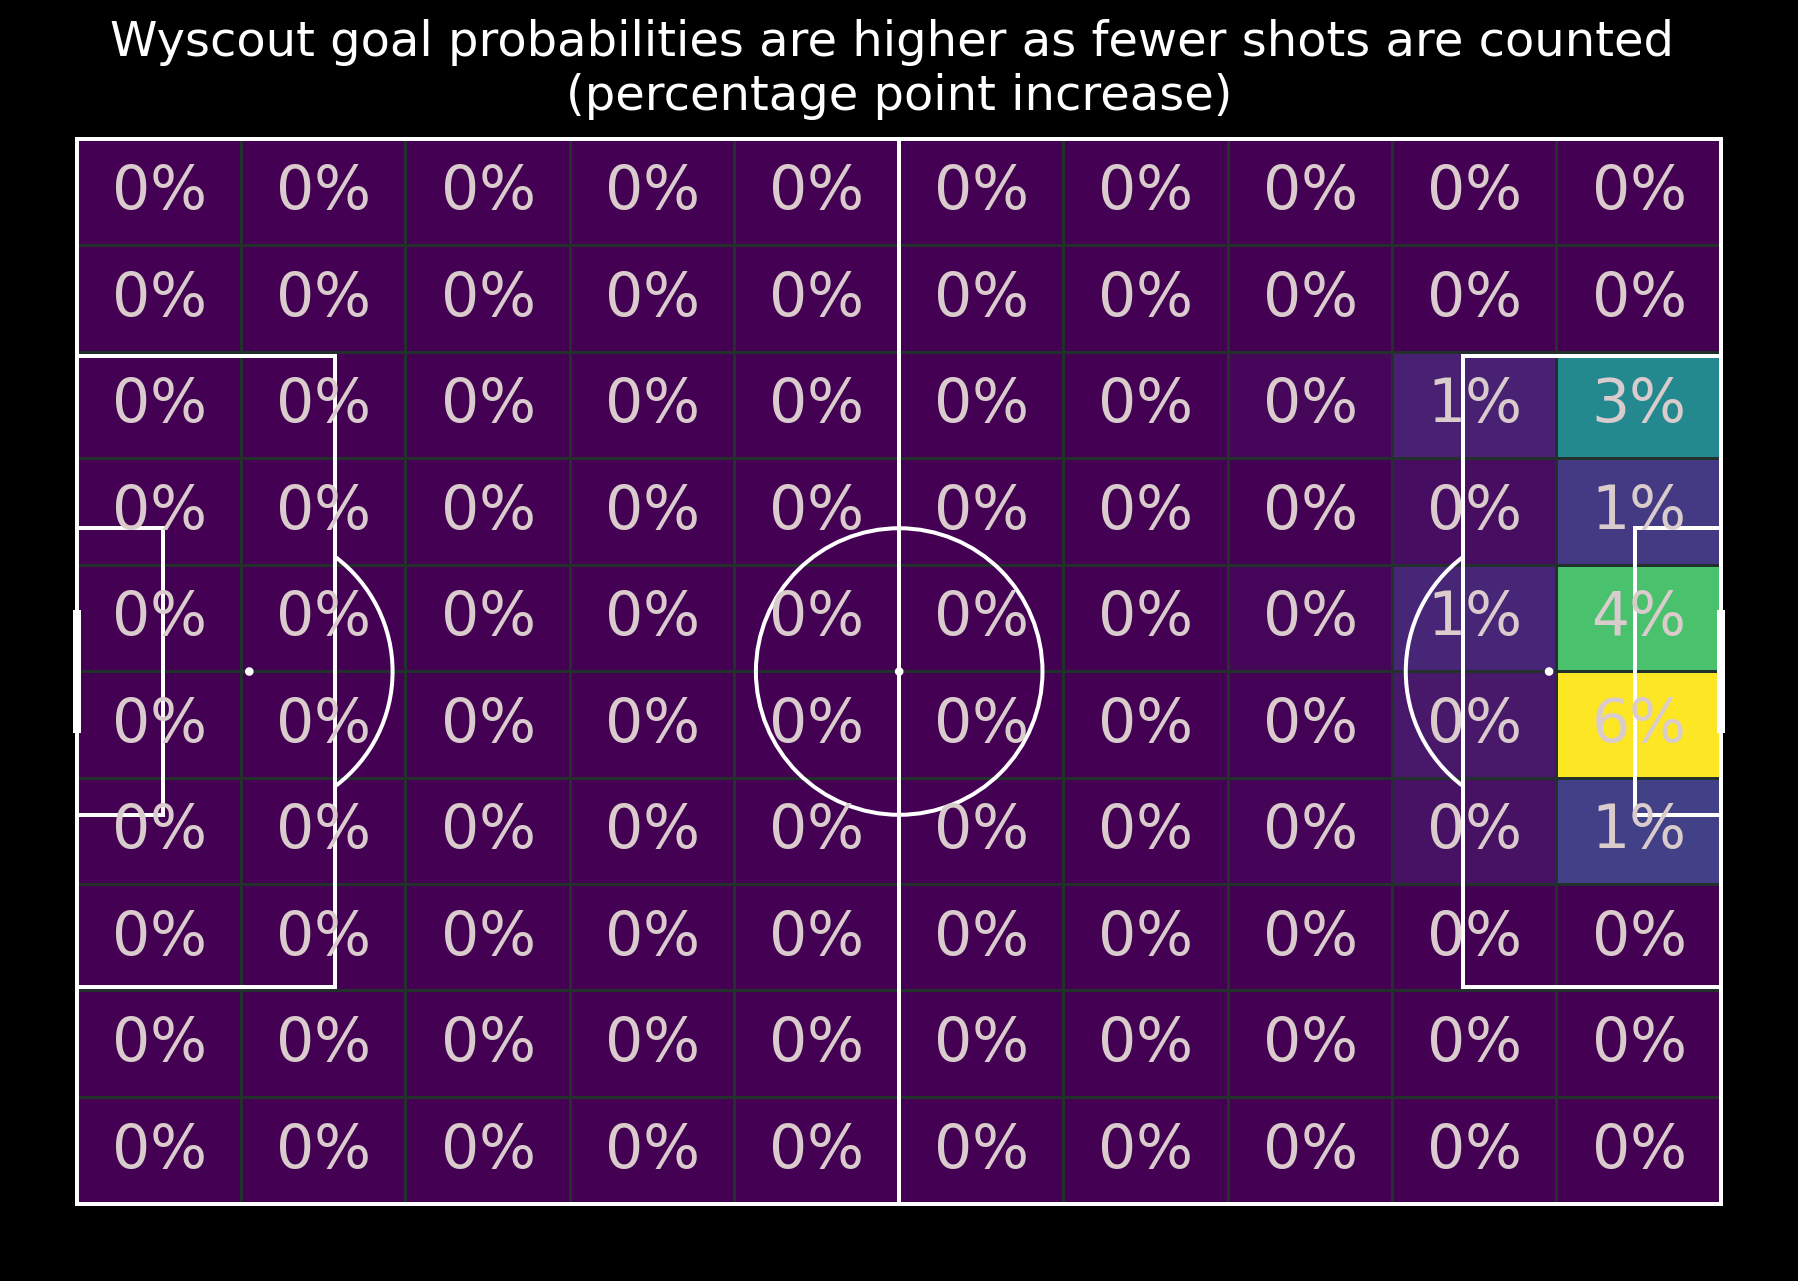

In [37]:
# goal probabilities for all shots
pitch = Pitch(pitch_type='statsperform', figsize=(16, 9), pad_top=8, line_zorder=3)
mask_goal = df_statsbomb_shots.outcome_name=='Goal'
bin_statistic_sb = pitch.bin_statistic(df_statsbomb_shots.x,
                                       df_statsbomb_shots.y,
                                       mask_goal,
                                       statistic='mean',
                                       bins=(5, 5))
# goal probabilities for matched shots
mask_goal = df_matched_shots.outcome_name=='Goal'
bin_statistic_match = pitch.bin_statistic(df_matched_shots.x_statsbomb,
                                          df_matched_shots.y_statsbomb,
                                          mask_goal,
                                          statistic='mean',
                                          bins=(5, 5))
# goal probabilities for all shots
mask_goal = df_statsbomb_shots.outcome_name=='Goal'
bin_statistic_sb = pitch.bin_statistic(df_statsbomb_shots.x,
                                       df_statsbomb_shots.y,
                                       mask_goal,
                                       statistic='mean',
                                       bins=(10, 10))
# goal probabilities for matched shots
mask_goal = df_matched_shots.outcome_name=='Goal'
bin_statistic_match = pitch.bin_statistic(df_matched_shots.x_statsbomb,
                                          df_matched_shots.y_statsbomb,
                                          mask_goal,
                                          statistic='mean',
                                          bins=(10, 10))
# calculate difference, i.e. what would happen if only have wyscout shots
bin_statistic_sb['statistic'] = np.nan_to_num(bin_statistic_match['statistic']) - np.nan_to_num(bin_statistic_sb['statistic'])
fig, ax = pitch.draw()
pcm = pitch.heatmap(bin_statistic_sb, ax=ax, cmap='viridis', edgecolors='#22312b', zorder=1)
bin_statistic_sb['statistic'] = (pd.DataFrame(bin_statistic_sb['statistic'])
                                 .applymap(lambda x: '{:.0%}'.format(x))
                                 .values)
label = pitch.label_heatmap(bin_statistic_sb, color='#DACCCC', fontsize=30, ax=ax, ha='center', va='center')
fig.suptitle('Wyscout goal probabilities are higher as fewer shots are counted \n(percentage point increase)', fontsize=24)
fig.savefig(os.path.join('figures', 'overlap_shot_differences_probabilities.png'), bbox_inches = 'tight', pad_inches = 0.2)

In [38]:
df_statsbomb_unmatched.outcome_name.value_counts()

Wayward    99
Blocked    55
Off T      42
Saved      21
Post        1
Name: outcome_name, dtype: int64

In [39]:
df_statsbomb_unmatched.body_part_name.value_counts() / len(df_statsbomb_unmatched.body_part_name)

Head          0.490826
Right Foot    0.298165
Left Foot     0.188073
Other         0.022936
Name: body_part_name, dtype: float64

In [40]:
df_statsbomb_unmatched[df_statsbomb_unmatched.body_part_name != 'Head'].outcome_name.value_counts()

Wayward    40
Blocked    38
Off T      20
Saved      13
Name: outcome_name, dtype: int64

In [41]:
df_statsbomb_unmatched[df_statsbomb_unmatched.body_part_name == 'Head'].outcome_name.value_counts()

Wayward    59
Off T      22
Blocked    17
Saved       8
Post        1
Name: outcome_name, dtype: int64

In [42]:
wayward = df_statsbomb_unmatched[df_statsbomb_unmatched.outcome_name == 'Wayward']
blocked = df_statsbomb_unmatched[df_statsbomb_unmatched.outcome_name == 'Blocked']
off_target = df_statsbomb_unmatched[df_statsbomb_unmatched.outcome_name == 'Off T']
other = df_statsbomb_unmatched[~df_statsbomb_unmatched.outcome_name.isin(['Wayward', 'Blocked', 'Off T'])]

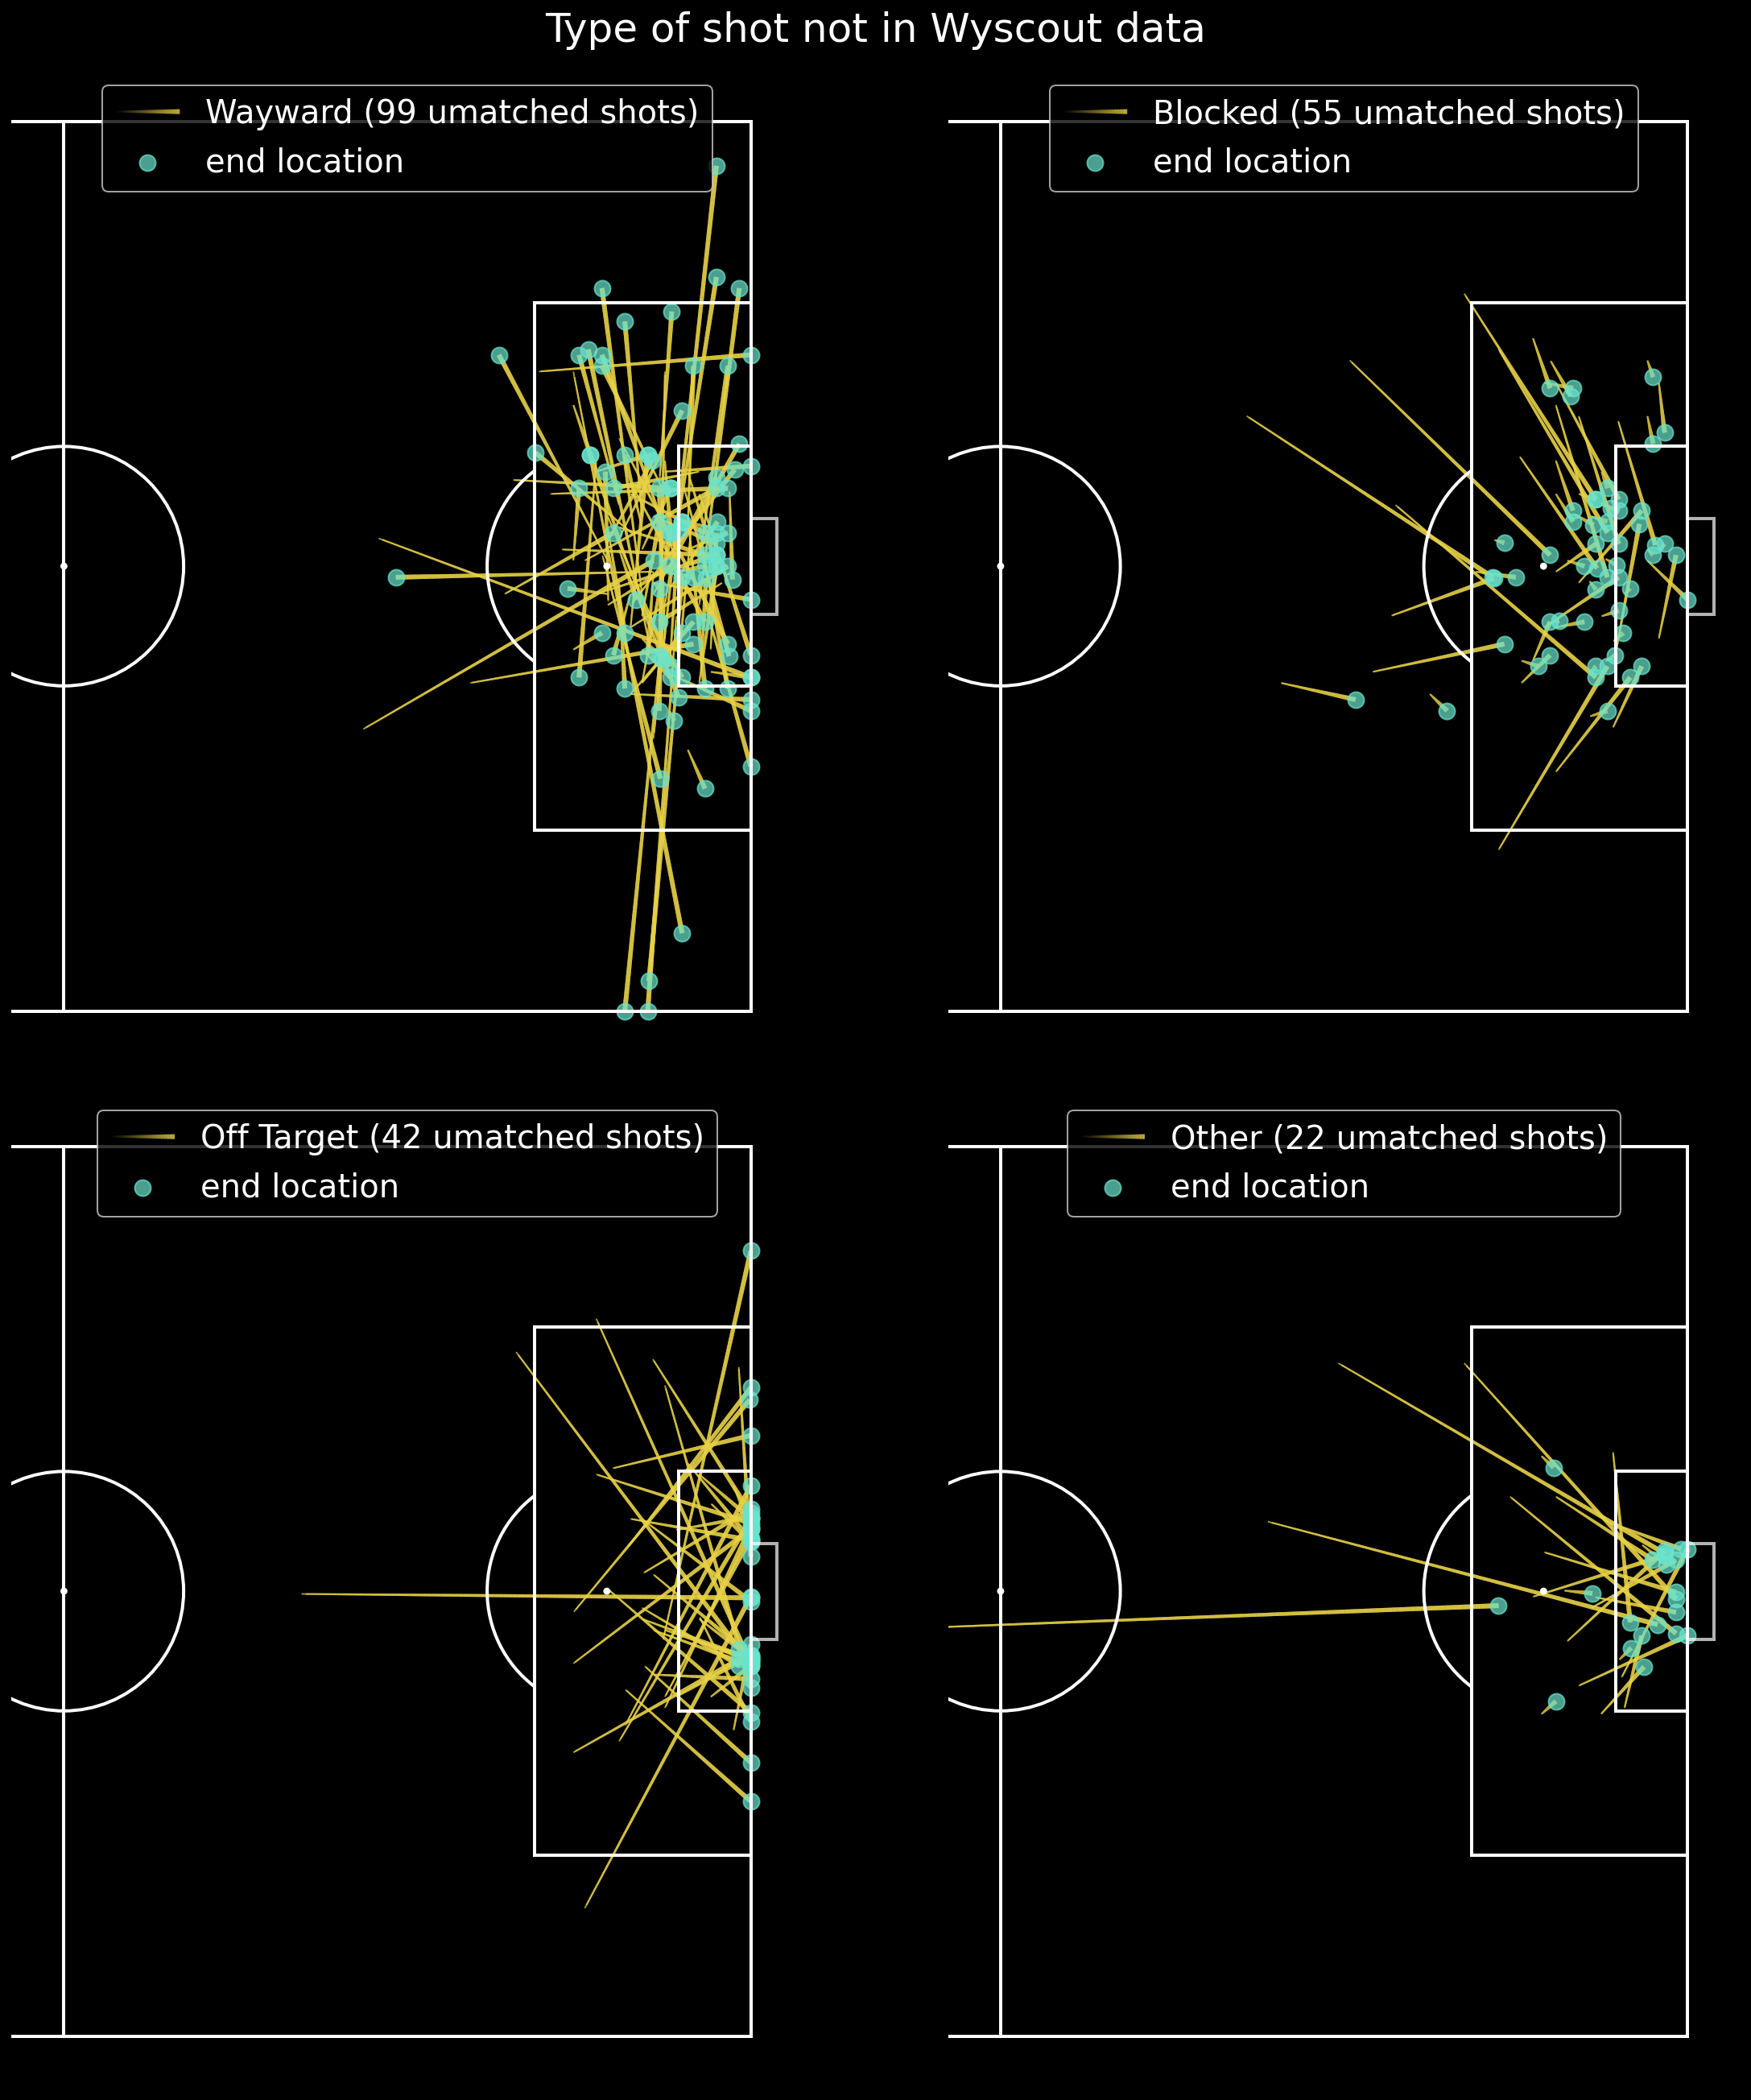

In [43]:
pitch_grid = Pitch(pitch_type='statsperform', figsize=(16, 18), view='half', line_zorder=3,
                   layout=(2, 2), constrained_layout=True, tight_layout=False, goal_type='box')
fig, ax = pitch_grid.draw()
ax = ax.ravel()
labels = ['Wayward', 'Blocked', 'Off Target', 'Other']
for i, df in enumerate([wayward, blocked, off_target, other]):
    pitch_grid.lines(df.x, df.y, df.end_x, df.end_y, alpha=0.7,
                     ax=ax[i], color='#e8d247', comet=True, transparent=True, lw=3,
                     label=f'{labels[i]} ({len(df)} umatched shots)')
    pitch_grid.scatter(df.end_x, df.end_y, ax=ax[i], s=100, c='#6ae4cd', alpha=0.7,
                       label='end location', zorder=2)
    ax[i].legend(loc='upper center', fontsize=20)
fig.suptitle('Type of shot not in Wyscout data', fontsize=25)
fig.savefig(os.path.join('figures', 'overlap_shot_type_unmatched.png'), bbox_inches = 'tight', pad_inches = 0.2)

Average distance between StatsBomb and Wyscout shot locations

In [44]:
distance = ((df_matched_shots.x_statsbomb - df_matched_shots.x_wyscout)**2 +
            (df_matched_shots.y_statsbomb - df_matched_shots.y_wyscout)**2)**0.5

In [45]:
x_diff = df_matched_shots.x_statsbomb - df_matched_shots.x_wyscout
y_diff = df_matched_shots.y_statsbomb - df_matched_shots.y_wyscout

In [46]:
pd.DataFrame({'x_diff': x_diff, 'y_diff': y_diff, 'distance': distance}).describe()

,x_diff,y_diff,distance
count,2386.000000,2386.000000,2386.000000
mean,1.637380,-0.249870,3.557034
std,3.673168,3.080878,3.615352
min,-7.787500,-17.935000,0.121989
25%,0.043750,-2.125000,1.839465
50%,1.312500,-0.297500,3.049718
75%,2.843750,1.615000,4.525746
max,85.312500,30.855000,86.780607


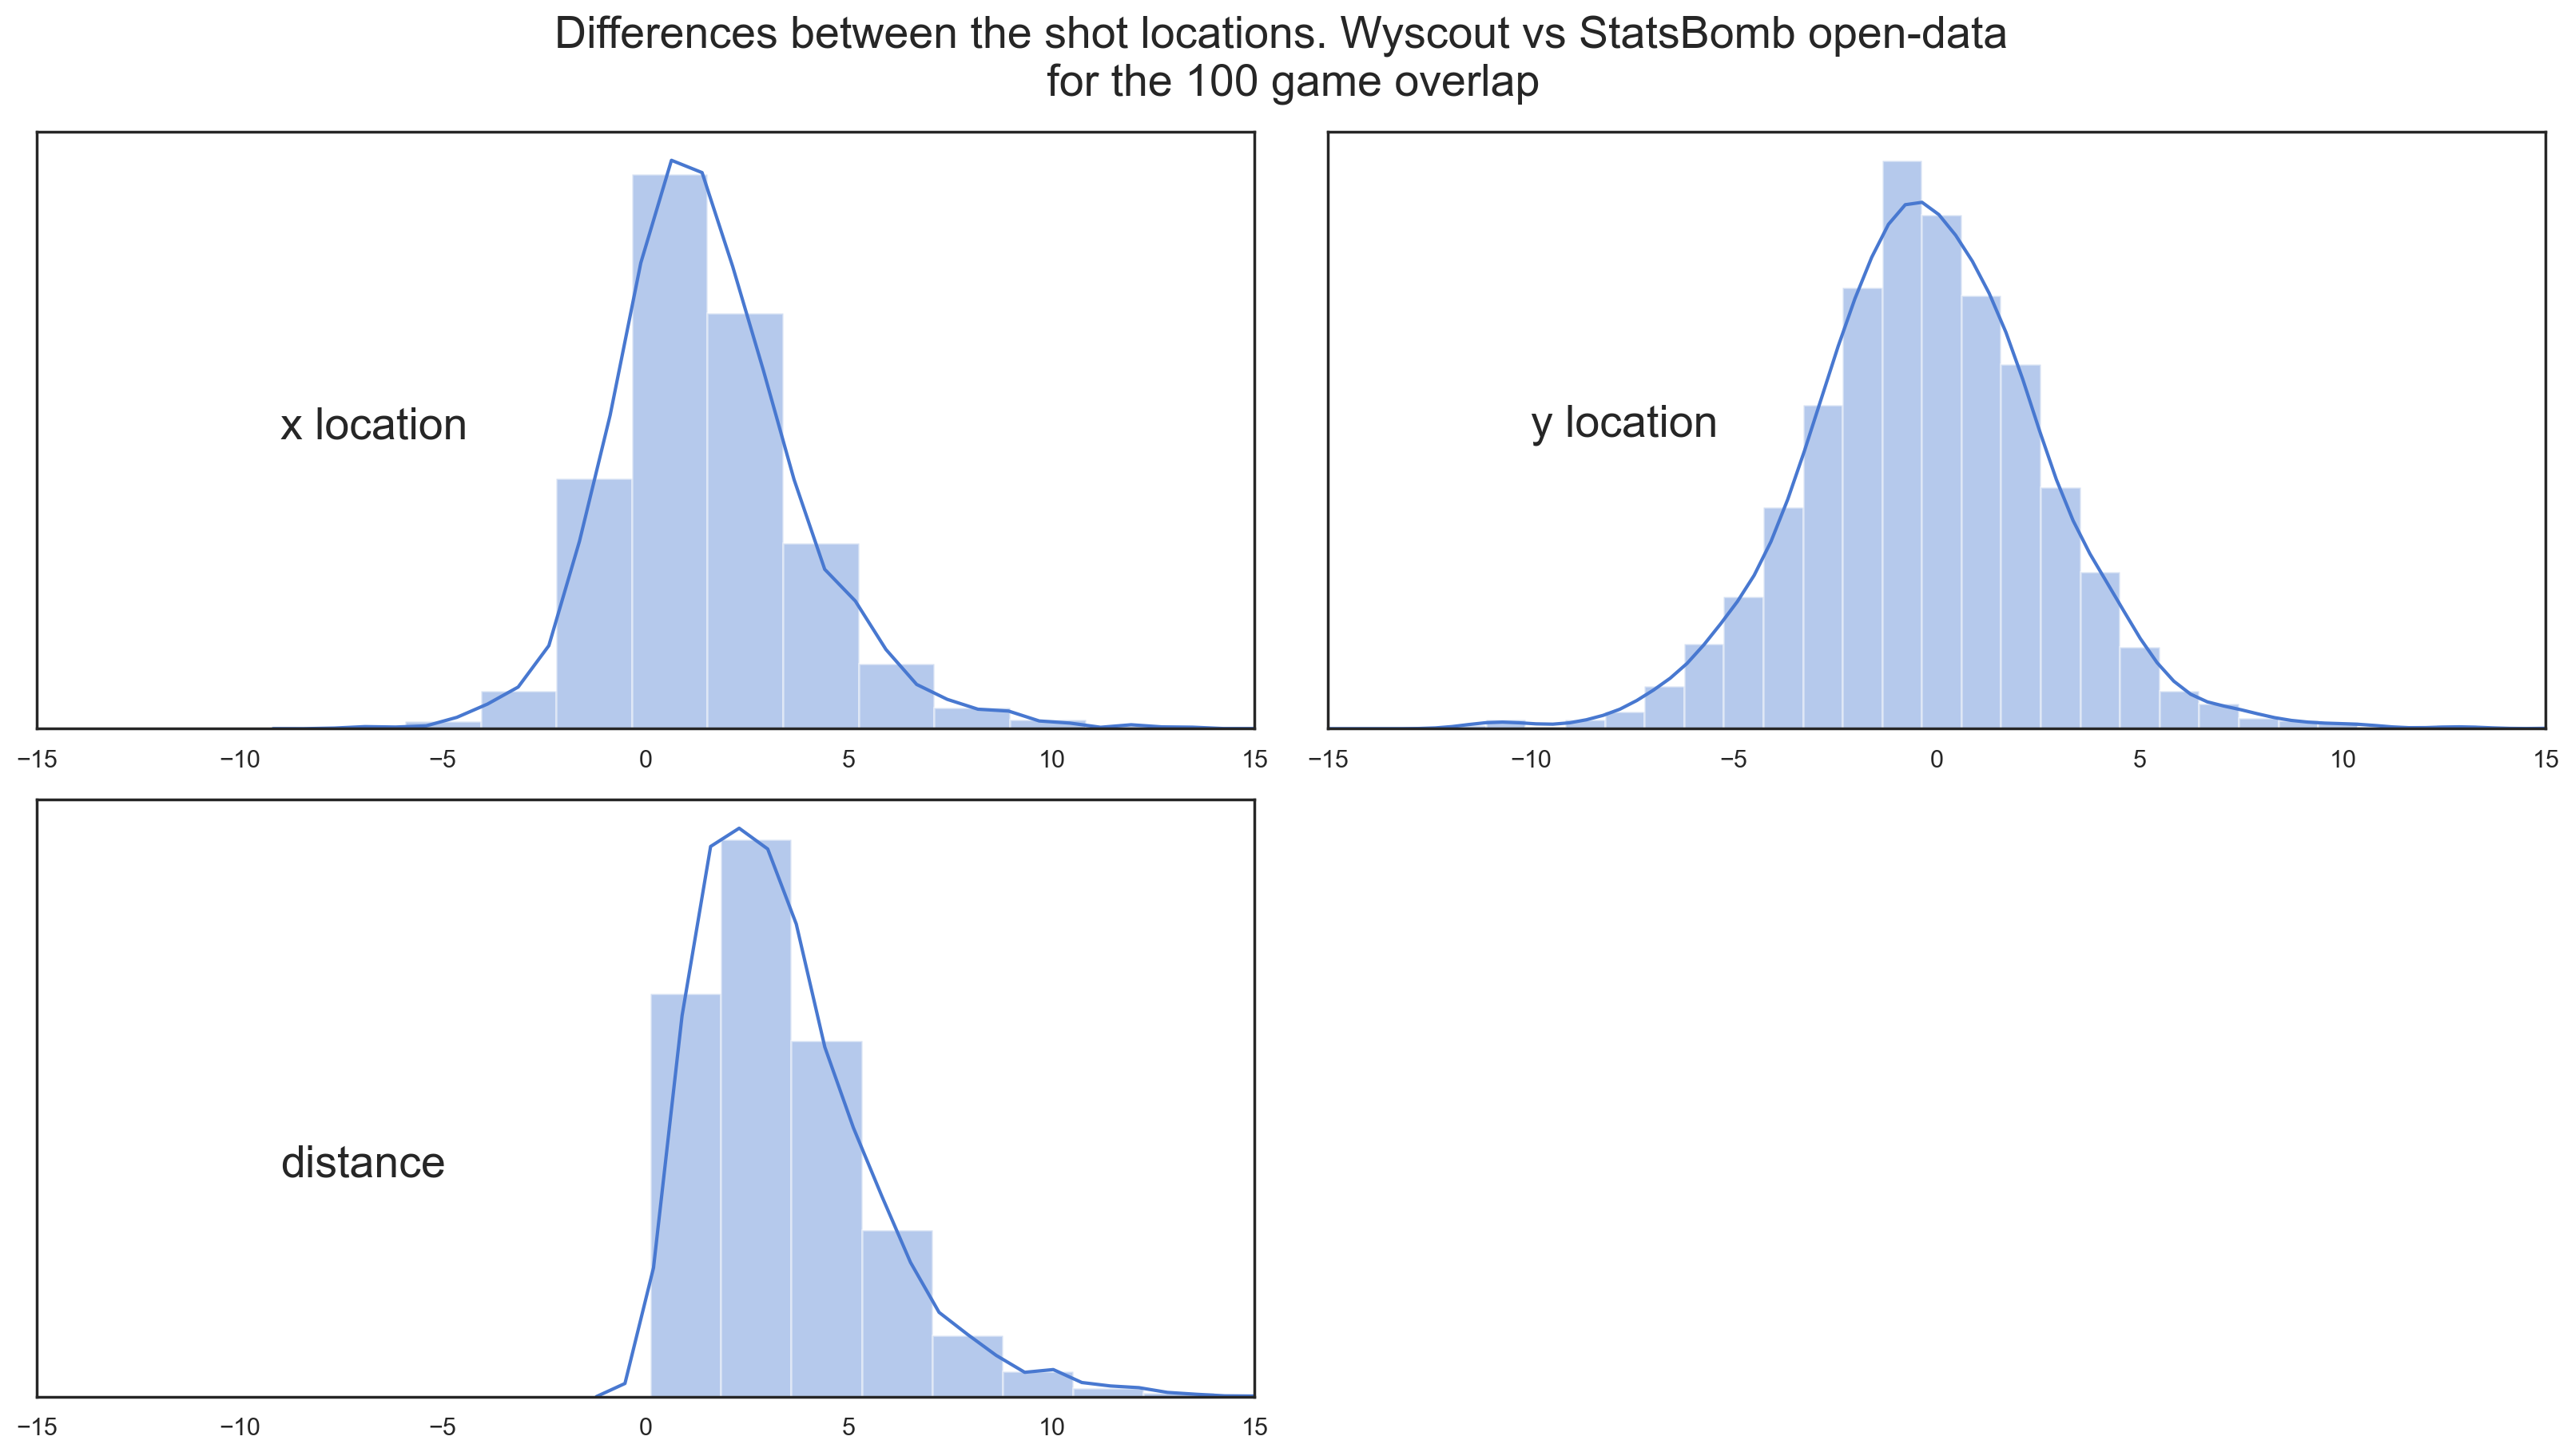

In [47]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set(style="white", palette="muted", color_codes=True)
fig, ax  = plt.subplots(2, 2, figsize=(16, 9), constrained_layout=True)
sns.distplot(x_diff, ax=ax[0, 0])
sns.distplot(y_diff, ax=ax[0, 1])
sns.distplot(distance, ax=ax[1, 0])
plt.setp(ax, yticks=[])
ax[0, 0].set_xlim(-15, 15)
ax[0, 0].annotate('x location', (-9, 0.1), fontsize=20)
ax[0, 1].set_xlim(-15, 15)
ax[0, 1].annotate('y location', (-10, 0.08), fontsize=20)
ax[1, 0].set_xlim(-15, 15)
ax[1, 0].annotate('distance', (-9, 0.08), fontsize=20)
ax[1, 1].remove()
fig.suptitle('Differences between the shot locations. Wyscout vs StatsBomb open-data \n for the 100 game overlap', fontsize=20)
fig.savefig(os.path.join('figures', 'overlap_difference_distribution.png'), bbox_inches = 'tight', pad_inches = 0.2)

Plots example match

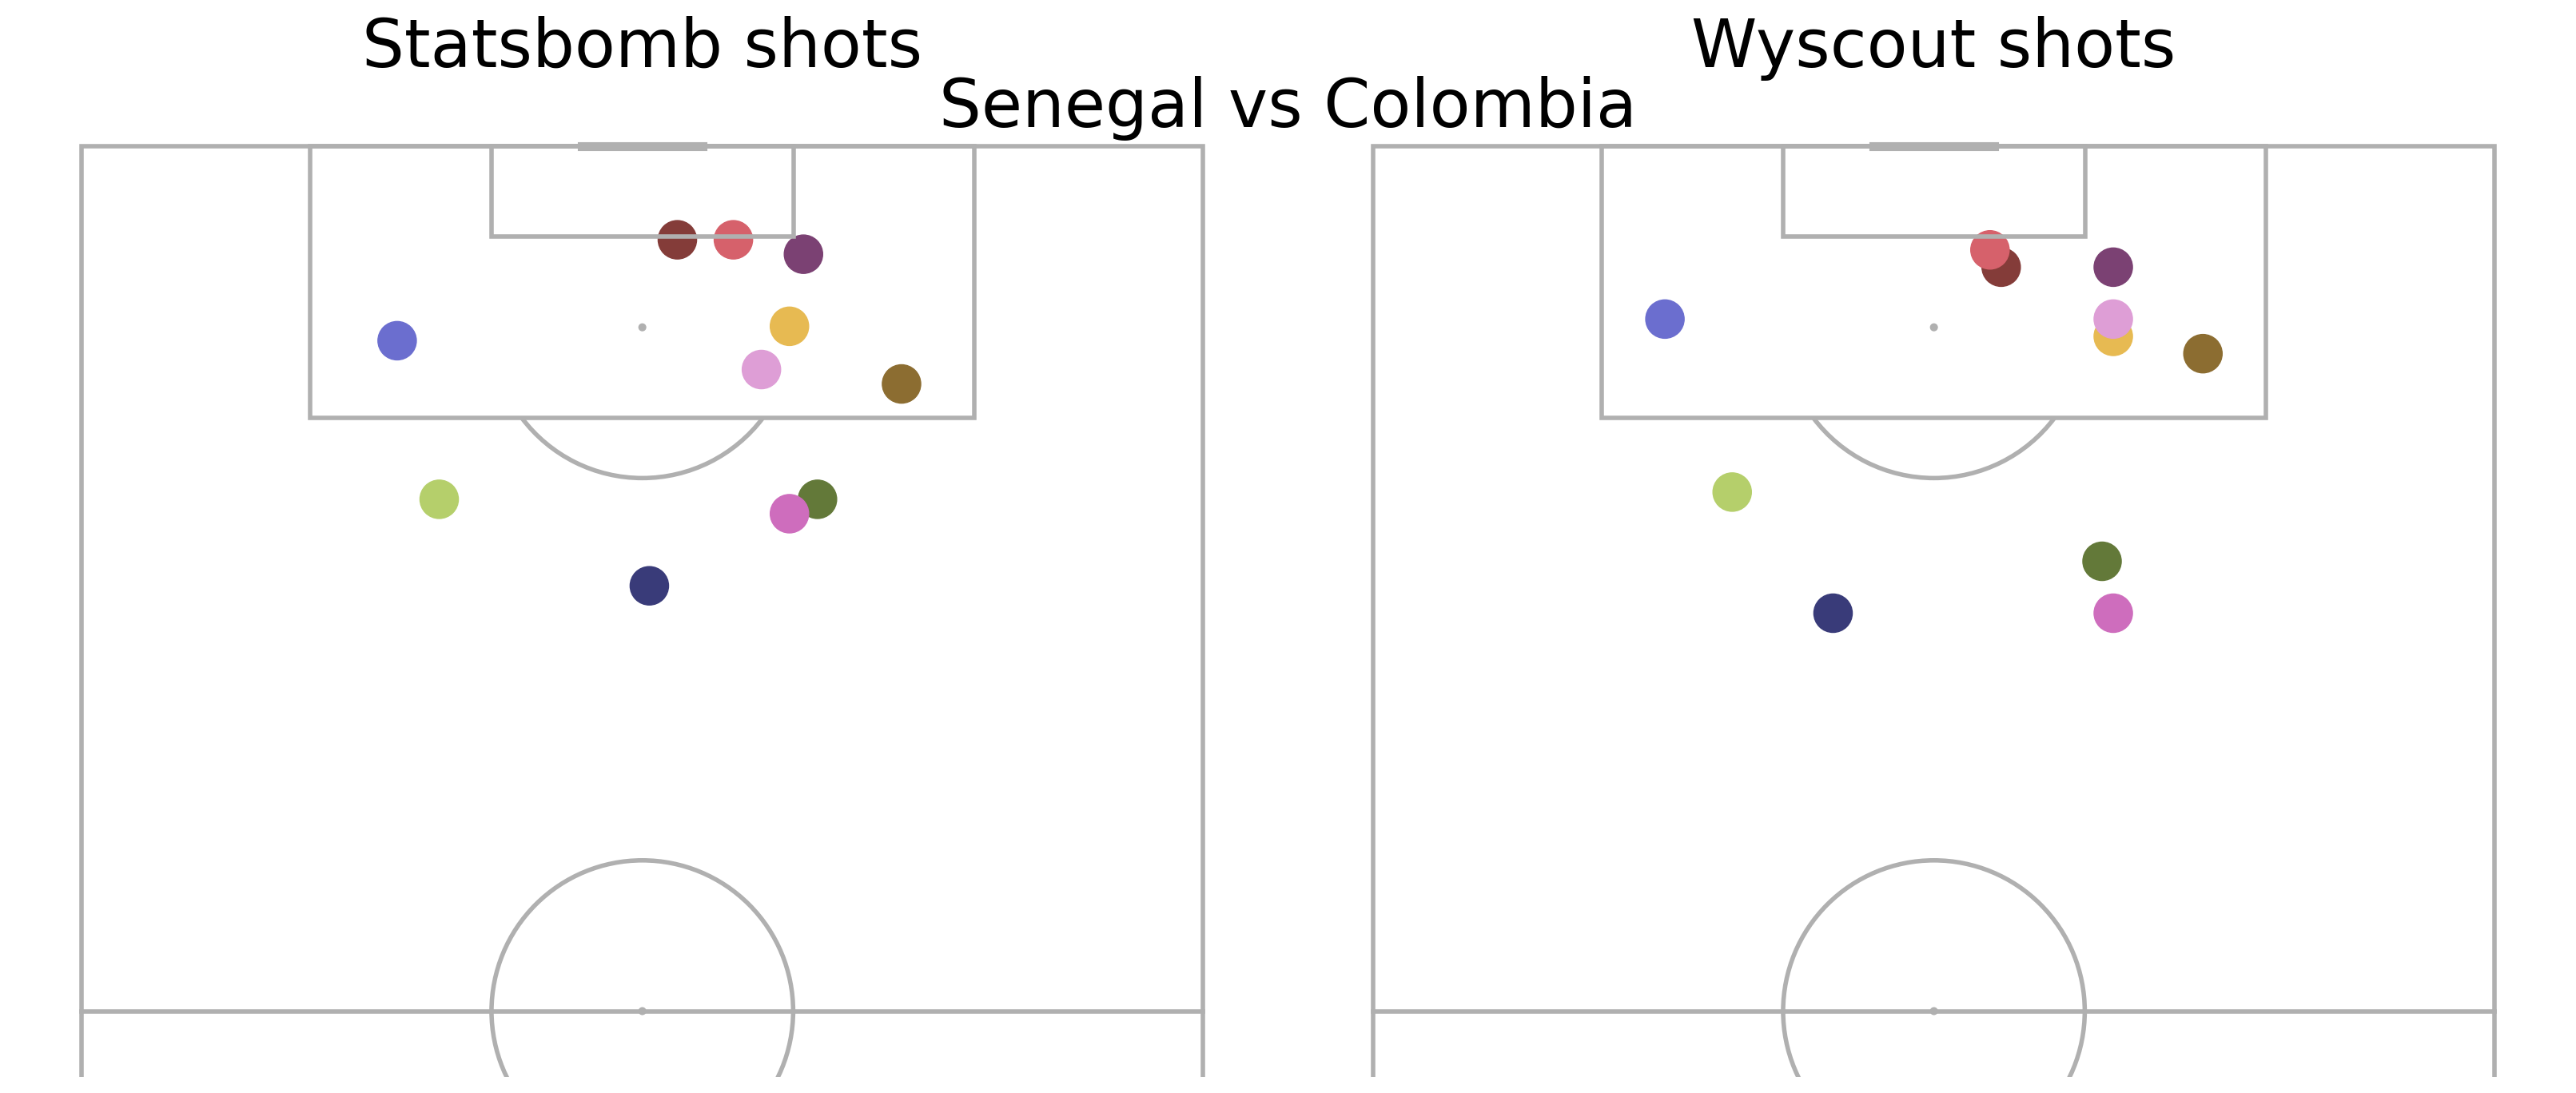

In [48]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('ggplot')
all_ids = df_statsbomb_shots.match_id_wyscout.unique()
idx = 1
subset = df_matched_shots[df_matched_shots.match_id_wyscout == all_ids[idx]].copy()
subset_match = df_wyscout_match[df_wyscout_match.match_id == all_ids[idx]]
team1 = subset_match.home_team_name.values[0]
team2 = subset_match.away_team_name.values[0]

fig, ax  = plt.subplots(1, 2, figsize=(16, 9), constrained_layout=True)
fig.suptitle(f'{team1} vs {team2}', fontsize=30, y=0.85, color='black')

pitch_statsperform.draw(ax=ax[0])
pitch_statsperform.scatter(subset.x_statsbomb, subset.y_statsbomb, c=np.arange(subset.y_statsbomb.size),
                           cmap='tab20b', ax=ax[0], s=300)
ax[0].set_title('Statsbomb shots', fontsize=30, color='black')

pitch_statsperform.draw(ax=ax[1])
pitch_statsperform.scatter(subset.x_wyscout, subset.y_wyscout, c=np.arange(subset.y_statsbomb.size),
                           cmap='tab20b', ax=ax[1], s=300)
ax[1].set_title('Wyscout shots', fontsize=30, color='black')
fig.savefig(os.path.join('figures', 'overlap_difference_example.png'), bbox_inches = 'tight', pad_inches = 0.2)